In [1]:
!pip install -U fsspec huggingface_hub sentence-transformers scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 8.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s eta 0:00:00:00:0100:01
  Attempting

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

2025-05-19 10:55:22.798090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747652123.001039      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747652123.061728      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/data/train-00000-of-00001.parquet")
texts = df['text'].tolist() 

In [19]:
print(df.head())

                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


In [48]:
num_labels = df['label'].nunique()
print(f"Number of unique labels: {num_labels}")

Number of unique labels: 4


In [4]:
embedder = SentenceTransformer('paraphrase-MiniLM-L12-v2')
embeddings = embedder.encode(texts, batch_size=64, show_progress_bar=True)
X_scaled = StandardScaler().fit_transform(embeddings)
X = torch.tensor(X_scaled, dtype=torch.float32)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

In [35]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=384, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), 
            nn.ReLU(),
            nn.Linear(256, 512), 
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z) 
        return out, z

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

train_loader = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001) 
criterion = nn.MSELoss()

In [37]:
model.train()
epochs=20
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        out, _ = model(x_batch)
        loss = criterion(out, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.3f}")

Epoch 1/20, Loss: 522.793
Epoch 2/20, Loss: 447.806
Epoch 3/20, Loss: 431.771
Epoch 4/20, Loss: 422.558
Epoch 5/20, Loss: 416.537
Epoch 6/20, Loss: 411.683
Epoch 7/20, Loss: 408.095
Epoch 8/20, Loss: 405.108
Epoch 9/20, Loss: 402.518
Epoch 10/20, Loss: 400.622
Epoch 11/20, Loss: 398.639
Epoch 12/20, Loss: 397.117
Epoch 13/20, Loss: 395.623
Epoch 14/20, Loss: 394.394
Epoch 15/20, Loss: 393.186
Epoch 16/20, Loss: 392.117
Epoch 17/20, Loss: 391.175
Epoch 18/20, Loss: 390.258
Epoch 19/20, Loss: 389.433
Epoch 20/20, Loss: 388.752


In [42]:
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    def forward(self, z):
        dist = torch.sum((z.unsqueeze(1) - self.cluster_centers.unsqueeze(0)) ** 2, dim=2)
        numerator = (1.0 + dist / self.alpha) ** (-(self.alpha + 1) / 2)
        q = numerator / torch.sum(numerator, dim=1, keepdim=True)
        return q

In [45]:
model.eval()
with torch.no_grad():
  _, latent_init = model(X.to(device))
  latent_np = latent_init.cpu().numpy()
  kmeans = KMeans(n_clusters=4, n_init=20).fit(latent_np)

clustering_layer = ClusteringLayer(n_clusters=4, latent_dim=32).to(device)
clustering_layer.cluster_centers.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

In [46]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [47]:
dec_optimizer = optim.Adam(list(model.parameters()) + list(clustering_layer.parameters()), lr=1e-3)
kl_loss = nn.KLDivLoss(reduction='batchmean')

epochs=15
for epoch in range(epochs):
  model.train()
  total_loss = 0
  for batch in train_loader:
    x_batch = batch[0].to(device)
    _, z = model(x_batch)
    q = clustering_layer(z)
    p = target_distribution(q).detach()
    loss = kl_loss(torch.log(q), p)
    dec_optimizer.zero_grad()
    loss.backward()
    dec_optimizer.step()
    total_loss += loss.item()

  
  with torch.no_grad():
    _, z_eval = model(X.to(device))
    kmeans_eval = KMeans(n_clusters=4).fit(z_eval.cpu().numpy())
    score = silhouette_score(z_eval.cpu().numpy(), kmeans_eval.labels_)
    print(f"Epoch {epoch+1}/{epochs}, KL Loss: {total_loss:.3f}, Silhouette Score: {score:.3f}")

Epoch 1/15, KL Loss: 76.404, Silhouette Score: 0.871
Epoch 2/15, KL Loss: 41.254, Silhouette Score: 0.904
Epoch 3/15, KL Loss: 29.094, Silhouette Score: 0.921
Epoch 4/15, KL Loss: 22.450, Silhouette Score: 0.931
Epoch 5/15, KL Loss: 18.313, Silhouette Score: 0.937
Epoch 6/15, KL Loss: 15.407, Silhouette Score: 0.943
Epoch 7/15, KL Loss: 13.221, Silhouette Score: 0.947
Epoch 8/15, KL Loss: 11.610, Silhouette Score: 0.953
Epoch 9/15, KL Loss: 10.376, Silhouette Score: 0.954
Epoch 10/15, KL Loss: 9.332, Silhouette Score: 0.955
Epoch 11/15, KL Loss: 8.673, Silhouette Score: 0.957
Epoch 12/15, KL Loss: 7.847, Silhouette Score: 0.959
Epoch 13/15, KL Loss: 7.239, Silhouette Score: 0.959
Epoch 14/15, KL Loss: 6.856, Silhouette Score: 0.963
Epoch 15/15, KL Loss: 6.339, Silhouette Score: 0.964


In [51]:
model.eval()
with torch.no_grad():
  _, final_latent = model(X.to(device))
  latent_np = final_latent.cpu().numpy()
  final_clusters = KMeans(n_clusters=4).fit_predict(latent_np)

  score = silhouette_score(latent_np, final_clusters)
  print(f"Final Silhouette Score: {score:.3f}")

Final Silhouette Score: 0.964


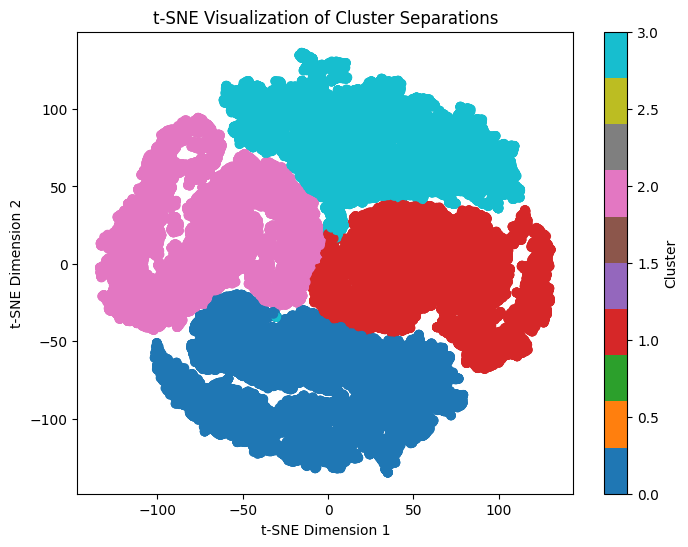

In [52]:
tsne = TSNE(n_components=2, random_state=30)
tsne_embeds = tsne.fit_transform(latent_np)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=final_clusters, cmap='tab10')
plt.colorbar(scatter, label='Cluster')
plt.title("t-SNE Visualization of Cluster Separations")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()